In [94]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5    # Axis line width
plt.rcParams['lines.linewidth'] = 1    # Line width
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['lines.markersize'] = 4
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [95]:
# Number of time steps
nt = 12

# Number of testing data
test_size = 200

# Number of branches
num_branches = 186

# Power flow limit
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category1.csv'
PF_max_category1 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category2.csv'
PF_max_category2 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category3.csv'
PF_max_category3 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()

# Set line flow threshold
epsilon = 0.95

PF_max1 = 200
PF_max2 = 300
PF_max3 = 500

PF_threshold = np.zeros((num_branches, nt))
PF_threshold[PF_max_category1, :] = epsilon * PF_max1
PF_threshold[PF_max_category2, :] = epsilon * PF_max2
PF_threshold[PF_max_category3, :] = epsilon * PF_max3

In [100]:
# Matrix to store results
branch_flow_true = []
branch_flow_pred = []

over_load_true = []
over_load_pred = []

# Read PF file
for i in range(test_size):
    # Ground truth
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    branch_flow_true.append(temp.copy())

    # Prediction
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    branch_flow_pred.append(temp.copy())

# Convert to numpy array
branch_flow_true = np.abs(np.array(branch_flow_true))
branch_flow_pred = np.abs(np.array(branch_flow_pred))

over_load_true = branch_flow_true >= PF_threshold
over_load_pred = branch_flow_pred >= PF_threshold

In [102]:
# Probability of heavying loading
prob_true = over_load_true.mean(axis=0)
prob_pred = over_load_pred.mean(axis=0)

# Get sorted branch index according to mean probability of ground truth
sorted_idx = np.argsort(prob_true.T.mean(axis=0))

# Select six important branches
num_top_branches = 9
top_branch_idx = sorted_idx[-num_top_branches:]

# Sort top branch index
# top_branch_idx = np.sort(top_branch_idx)

top_branch_idx

array([172,  53, 150,  37,   6,   8, 174, 175, 133])

## All branches

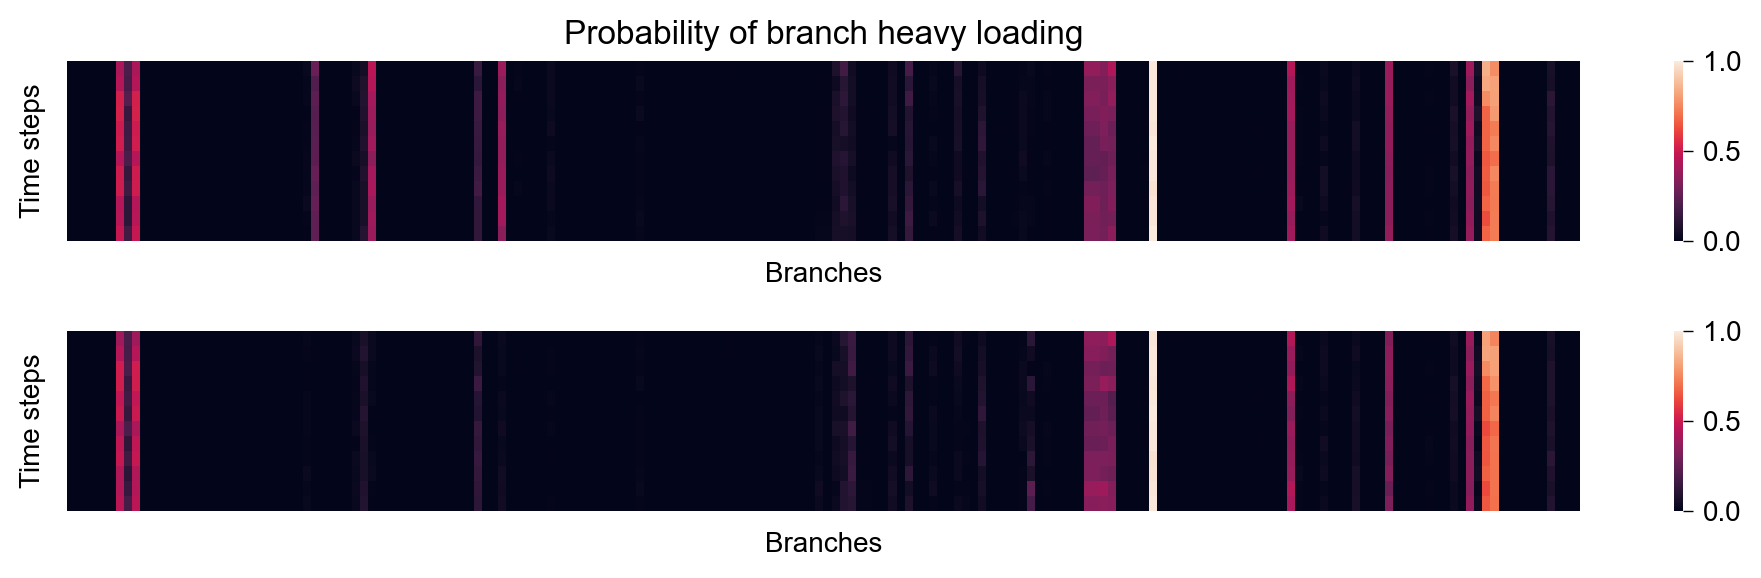

In [104]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(211)
sns.heatmap(prob_true.T, ax=ax1, vmin=0, vmax=1, xticklabels=[], yticklabels=[])
ax1.set_title('Probability of branch heavy loading')
ax1.set_xlabel('Branches')
ax1.set_ylabel('Time steps')

ax2 = fig.add_subplot(212)
sns.heatmap(prob_pred.T, ax=ax2, vmin=0, vmax=1, xticklabels=[], yticklabels=[])
ax2.set_xlabel('Branches')
ax2.set_ylabel('Time steps')

plt.tight_layout()
plt.show()
plt.close('all')

## Significant branches

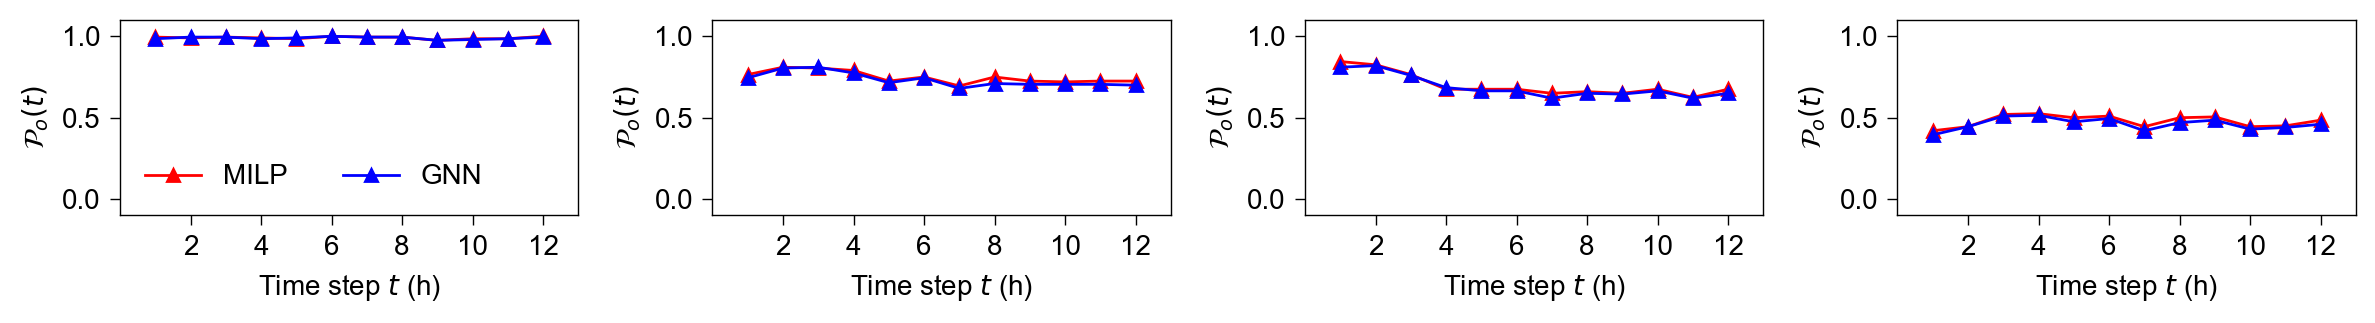

In [106]:
# Plot probability for individual branch
fig = plt.figure(figsize=(12, 1.75))

x = np.arange(1, 13)

ax = fig.add_subplot(141)
ax.plot(x, prob_true[top_branch_idx[-1]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[-1]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}_o(t)$')
ax.legend(loc='lower left', ncols=2, frameon=False)

ax = fig.add_subplot(142)
ax.plot(x, prob_true[top_branch_idx[-2]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[-2]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}_o(t)$')

ax = fig.add_subplot(143)
ax.plot(x, prob_true[top_branch_idx[-3]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[-3]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}_o(t)$')
# ax.legend(loc='upper right', ncols=2, frameon=False)

ax = fig.add_subplot(144)
ax.plot(x, prob_true[top_branch_idx[-4]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[-4]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}_o(t)$')
# ax.legend(loc='upper right', ncols=2, frameon=False)


plt.tight_layout()
plt.show()
plt.close('all')

## Conditional probability

The conditional probability of individual branch to be overloading at $t+1$, $t+2$, ..., $t+\Delta T$ if it is overloaded at $t$

In [133]:
# Number of time steps
T = 12
delta_T = 3

cond_prob_true = np.zeros((num_branches, T))
cond_prob_pred = np.zeros((num_branches, T))

# Calculate conditional probability ground truth
for i in range(num_branches):
    for j in range(T-delta_T):
        idx = over_load_true[:, sorted_idx[-(i+1)], j] == True
        num = (over_load_true[idx, sorted_idx[-(i+1)], j+1:j+1+delta_T] == True).sum(axis=1)
        cond_prob_true[i, j] = (num >= delta_T).sum() / idx.sum()

# Calculate conditional probability prediction
for i in range(num_branches):
    for j in range(T-delta_T):
        idx = over_load_pred[:, sorted_idx[-(i+1)], j] == True
        num = (over_load_pred[idx, sorted_idx[-(i+1)], j+1:j+1+delta_T] == True).sum(axis=1)
        cond_prob_pred[i, j] = (num >= delta_T).sum() / idx.sum()

/var/folders/cn/s2z4sz3n33n4m238vt6kj7j40000gn/T/ipykernel_39677/416882704.py:13: RuntimeWarning: invalid value encountered in long_scalars
  cond_prob_true[i, j] = (num >= delta_T).sum() / idx.sum()
/var/folders/cn/s2z4sz3n33n4m238vt6kj7j40000gn/T/ipykernel_39677/416882704.py:20: RuntimeWarning: invalid value encountered in long_scalars
  cond_prob_pred[i, j] = (num >= delta_T).sum() / idx.sum()


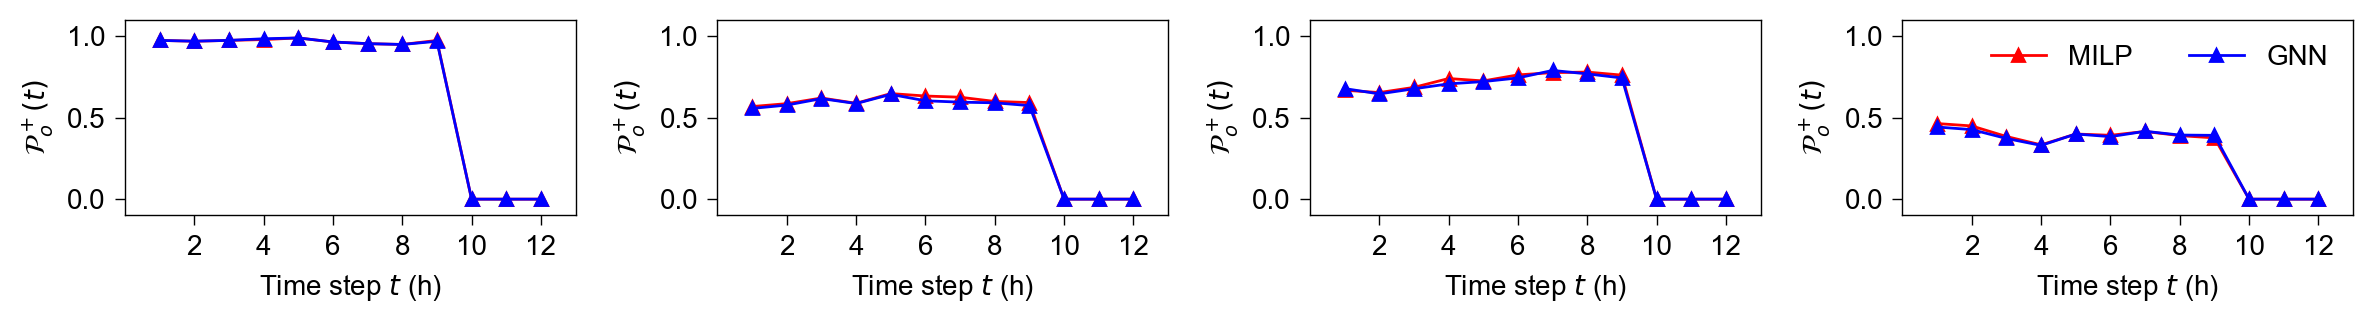

In [144]:
# Plot probability for individual branch
fig = plt.figure(figsize=(12, 1.75))

x = np.arange(1, 13)

ax = fig.add_subplot(141)
ax.plot(x, cond_prob_true[0], color='red', marker='^', label='MILP')
ax.plot(x, cond_prob_pred[0], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}^+_o(t)$')
# ax.legend(loc='lower left', ncols=2, frameon=False)

ax = fig.add_subplot(142)
ax.plot(x, cond_prob_true[1], color='red', marker='^', label='MILP')
ax.plot(x, cond_prob_pred[1], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}^+_o(t)$')

ax = fig.add_subplot(143)
ax.plot(x, cond_prob_true[2], color='red', marker='^', label='MILP')
ax.plot(x, cond_prob_pred[2], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}^+_o(t)$')
# ax.legend(loc='upper right', ncols=2, frameon=False)

ax = fig.add_subplot(144)
ax.plot(x, cond_prob_true[3], color='red', marker='^', label='MILP')
ax.plot(x, cond_prob_pred[3], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylim((-0.1, 1.1))
ax.set_ylabel('$\mathcal{P}^+_o(t)$')
ax.legend(loc='upper right', ncols=2, frameon=False)


plt.tight_layout()
plt.show()
plt.close('all')

## Risk analysis

In [109]:
# Define cost function
Co = 1 # Cost of overloading, $1/MW
Co_prime = np.linspace(Co/delta_T/1.5, Co/delta_T/5, delta_T) # Conditional cost of shedding, $/MW

## Risk associated with shedding at time t
cost_true = branch_flow_true * Co
cost_pred = branch_flow_pred * Co
risk_true = cost_true.mean(axis=0).mean(axis=0)
risk_pred = cost_pred.mean(axis=0).mean(axis=0)

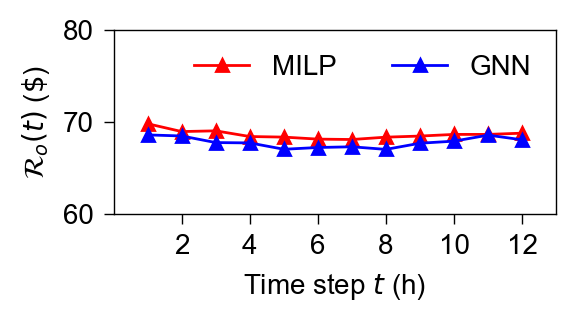

In [132]:
# Plot risk
x = np.arange(1, 13)

fig = plt.figure(figsize=(3, 1.75))
ax = fig.add_subplot(111)
ax.plot(x, risk_true, color='red', marker='^', label='MILP')
ax.plot(x, risk_pred, color='blue', marker='^', label='GNN')
ax.set_xlabel('Time step $t$ (h)')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_ylim((60, 80))
ax.set_ylabel('$\mathcal{R}_o(t)$ ($\$$)')
ax.legend(ncols=2, frameon=False)

plt.tight_layout()
plt.show()
plt.close('all')
